# Giải thuật linear regression cho bàitoán advertising

## Giới thiệu bài toán

Tóm tắt:
- Bài toán: Dựa trên 3 thông tin đầu vào là TV, Radio, Newspaper để dự đoán Sale
- Giới thiệu về tập data:Data có 200 samples (rows), gồm 4 cột thông tin Tv, Radio, Newspaper,và Sales. Đề bài yêu cầu dùng thông tin ở 3 cột đầu tiên (Tv, Radio, Newspaper) để dự đoánđược cột cuối cùng (Sale) dùng linear regression model.

Phương pháp:
Code về giải thuật linear regression cho bàitoán advertising theo cách vectorization dùng:
- stochastic gradient descent
- m samples (mini-batchgradient descent)
- N samples (batch gradient descent).

In [2]:
import numpy as np
# from numpy import genfromtxt
import matplotlib.pyplot as plt

In [ ]:
!pip install -q gdown
# !sudo apt-get install -y -q unzip
# !gdown 1x3OX304PO-bonyooK4FKcRhyrTmT4kif -O advertising.zip
!gdown 1x3OX304PO-bonyooK4FKcRhyrTmT4kif
!unzip advertising.zip
#

Downloading...
From: https://drive.google.com/uc?id=1x3OX304PO-bonyooK4FKcRhyrTmT4kif
To: /home/banhmuy/zero-to-hero/DataScienceAndArtificialIntelligence/LinearRegression/advertising.zip
100%|██████████████████████████████████████| 1.90k/1.90k [00:00<00:00, 3.13MB/s]
Archive:  advertising.zip
  inflating: advertising.csv         


## Chuẩn hóa data đầu vào

In [3]:
data = np.genfromtxt('advertising.csv', delimiter=',', skip_header=1)
print(data[:5,:])
print(data.shape)

[[230.1  37.8  69.2  22.1]
 [ 44.5  39.3  45.1  10.4]
 [ 17.2  45.9  69.3  12. ]
 [151.5  41.3  58.5  16.5]
 [180.8  10.8  58.4  17.9]]
(200, 4)


[Mean Normalization](https://builtin.com/articles/mean-normalization)

$$
x^{'}=\frac{x - \mu}{max(x) - min(x)}
$$

In [4]:
# Normalize input data by using mean normalization
def mean_normalization(X):
    """
    Input: X
    Return:
    - X_bias: X after normalize
    - min_X: Min value of X
    - max_X: Max value of X
    - avg_X: Average value of X
    """
    min_X = np.min(X)
    max_X = np.max(X)
    avg_X = np.mean(X)
    X_norm = (X - avg_X) / (max_X - min_X)
    X_bias = np.c_[np.ones((X.shape[0], 1)), X_norm]

    return X_bias, min_X, max_X, avg_X

In [5]:
N = data.size
max_cols_index = data.shape[1] - 1
X = data[:, :max_cols_index]
y = data[:, max_cols_index:]

X_bias, min_X, max_X, avg_X = mean_normalization(X)

# Debug: Check shape and values of the variables
print("=== DEBUG INFO ===")
print("Shape of X:", X.shape)
print("Sample values of X (first 5 elements):", X[:5])
print("Shape of y:", y.shape)
print("Sample values of y (first 5 elements):", y[:5])

print("Shape of X_bias:", X_bias.shape)
print("Sample values of X_bias (first 5 elements):", X_bias[:5])

print("\nShape of min_X:", min_X.shape if hasattr(min_X, 'shape') else "Scalar")
print("Value of min_X:", min_X)
print("Shape of max_X:", max_X.shape if hasattr(max_X, 'shape') else "Scalar")
print("Value of max_X:", max_X)
print("Shape of avg_X:", avg_X.shape if hasattr(avg_X, 'shape') else "Scalar")
print("Value of avg_X:", avg_X)
print("==================")


=== DEBUG INFO ===
Shape of X: (200, 3)
Sample values of X (first 5 elements): [[230.1  37.8  69.2]
 [ 44.5  39.3  45.1]
 [ 17.2  45.9  69.3]
 [151.5  41.3  58.5]
 [180.8  10.8  58.4]]
Shape of y: (200, 1)
Sample values of y (first 5 elements): [[22.1]
 [10.4]
 [12. ]
 [16.5]
 [17.9]]
Shape of X_bias: (200, 4)
Sample values of X_bias (first 5 elements): [[ 1.          0.55042679 -0.09835864  0.00757928]
 [ 1.         -0.07575405 -0.09329791 -0.07372976]
 [ 1.         -0.16785931 -0.0710307   0.00791667]
 [ 1.          0.2852446  -0.08655027 -0.02852058]
 [ 1.          0.3840975  -0.18945175 -0.02885796]]

Shape of min_X: ()
Value of min_X: 0.0
Shape of max_X: ()
Value of max_X: 296.4
Shape of avg_X: ()
Value of avg_X: 66.95349999999999


**So sánh**

| Loại GD           | Dữ liệu dùng mỗi lần                    | Tốc độ   | Độ ổn định      |Ưu điểm                    | Nhược điểm                  |
| ----------------- | --------------------------------------- | -------- | --------------- |-------------------------- | --------------------------- |
| **Batch GD**      | Toàn bộ dataset                         | Chậm     | Ổn định         | Ổn định                    | Chậm                        |
| **SGD**           | 1 mẫu                                   | Nhanh    | Dao động mạnh   | Nhanh, phù hợp dataset lớn | Dao động                    |
| **Mini-batch GD** | Một nhóm nhỏ (batch_size = 32, 64, ...) | Cân bằng | Ổn định hơn SGD | Cân bằng tốt               | Cần chọn batch size phù hợp |



## Stochastic Gradient Descent(SGD)

Thuật toán này chỉ sử dụng một điểm dữ liệu tại mỗi lần tính toán gradient và cập nhật tham số mô hình.

In [6]:
def predict(theta, x):
    return x.dot(theta)

def compute_loss(y_hat, y):
    return (y_hat - y) ** 2

def compute_gradient(x, y, y_hat):
    return 2 * x * (y_hat - y)

def update_gradient(theta, dtheta, learning_rate):
    return theta - learning_rate * dtheta

In [9]:
def stochastic_gradient_descent(X_bias, y, n_epochs=50, learning_rate=0.01):
    """
    Input:
    - X_bias: X add bias
    - y: label
    - n_epochs: number of epochs
    - learning_rate

    Output:
    - thetas_path:
    - losses:
    """
    # Number of samples
    N = len(y)
    losses = []
    losses_for_each_epoch = []

    thetas = np.asarray([[1.16270837], [-0.81960489],
                         [1.39501033],  [0.29763545]])
    thetas_path = [thetas.copy()]

    print(f"[INIT SHAPES] y={y.shape}, X_bias={X_bias.shape}, thetas={thetas.shape}")
    for epoch in range(n_epochs):
        print(f"\n========== EPOCH {epoch + 1}/{n_epochs} ==========")
        epoch_losses = []
        for i in range(N):
            # Take a sample
            # random index  = i
            xi = X_bias[i:i + 1]
            yi = y[i:i + 1]

            # Predict
            y_hat = predict(thetas, xi)

            # Compute loss
            loss = compute_loss(y_hat, yi)
            epoch_losses.append(loss[0][0])
            losses.append(loss[0][0])

            # Compute gradient
            dtheta = compute_gradient(xi, yi, y_hat)

            # Update gradient
            thetas = update_gradient(thetas, dtheta, learning_rate)
            thetas_path.append(thetas)
            if i == 1:
                print(f"  xi.shape={xi.shape}, yi.shape={yi.shape}")
                print(f"  y_hat.shape={y_hat.shape}")
                print(f"  loss.shape={loss.shape}, loss={loss[0][0]:.6f}")
                print(f"  gradients.shape={dtheta.shape}")
                print(f"  theta.shape={thetas.shape}")


        mean_loss = np.sum(epoch_losses) / len(epoch_losses)
        losses_for_each_epoch.append(mean_loss)
        print(f"[EPOCH {epoch+1}] mean_loss={mean_loss:.6f}")
    return thetas_path, losses



In [10]:
thetas_path, losses = stochastic_gradient_descent(X_bias, y, n_epochs=50, learning_rate=0.01)

[INIT SHAPES] y=(200, 1), X_bias=(200, 4), thetas=(4, 1)

========== EPOCH 1/50 ==========
  xi.shape=(1, 4), yi.shape=(1, 1)
  y_hat.shape=(1, 4)
  loss.shape=(1, 4), loss=81.024148
  gradients.shape=(1, 4)
  theta.shape=(4, 4)
[EPOCH 1] mean_loss=34.140045

========== EPOCH 2/50 ==========
  xi.shape=(1, 4), yi.shape=(1, 1)
  y_hat.shape=(1, 4)
  loss.shape=(1, 4), loss=2.374662
  gradients.shape=(1, 4)
  theta.shape=(4, 4)
[EPOCH 2] mean_loss=4.467294

========== EPOCH 3/50 ==========
  xi.shape=(1, 4), yi.shape=(1, 1)
  y_hat.shape=(1, 4)
  loss.shape=(1, 4), loss=2.977892
  gradients.shape=(1, 4)
  theta.shape=(4, 4)
[EPOCH 3] mean_loss=4.454053

========== EPOCH 4/50 ==========
  xi.shape=(1, 4), yi.shape=(1, 1)
  y_hat.shape=(1, 4)
  loss.shape=(1, 4), loss=2.989067
  gradients.shape=(1, 4)
  theta.shape=(4, 4)
[EPOCH 4] mean_loss=4.453976

========== EPOCH 5/50 ==========
  xi.shape=(1, 4), yi.shape=(1, 1)
  y_hat.shape=(1, 4)
  loss.shape=(1, 4), loss=2.989262
  gradients.shap

Text(0, 0.5, 'loss')

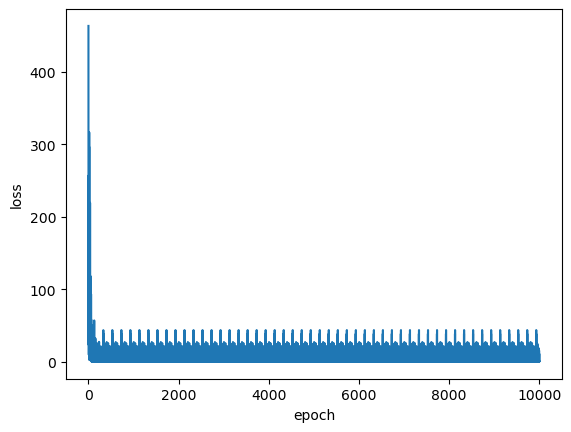

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0.5, 1.0, 'Losses through epochs using SGD training in Adsvertising data')

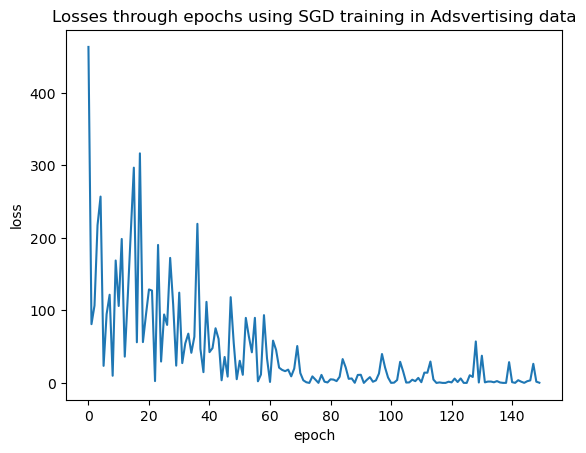

In [14]:
plt.plot(losses[:150])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Losses through epochs using SGD training in Adsvertising data")

## Mini-bach Gradient Descent

## Batch Gradient Descent

## Kết luận: